# ОБУЧЕНИЕ СЕМАНТИЧЕСКОЙ СЕГМЕНТАЦИИ 

Обучение семантической сегментации на примере датасета Nail_segmentation, взятого с платформы kaggle

Структура данных:
- images_train, labels_train - Тренировочный датасет изображений и масок
- images_valid, labels_valid - изображения и маски валидационного датасета

In [1]:
!conda init
!conda activate CV

no change     C:\ProgramData\anaconda3\Scripts\conda.exe
no change     C:\ProgramData\anaconda3\Scripts\conda-env.exe
no change     C:\ProgramData\anaconda3\Scripts\conda-script.py
no change     C:\ProgramData\anaconda3\Scripts\conda-env-script.py
no change     C:\ProgramData\anaconda3\condabin\conda.bat
no change     C:\ProgramData\anaconda3\Library\bin\conda.bat
no change     C:\ProgramData\anaconda3\condabin\_conda_activate.bat
no change     C:\ProgramData\anaconda3\condabin\rename_tmp.bat
no change     C:\ProgramData\anaconda3\condabin\conda_auto_activate.bat
no change     C:\ProgramData\anaconda3\condabin\conda_hook.bat
no change     C:\ProgramData\anaconda3\Scripts\activate.bat
no change     C:\ProgramData\anaconda3\condabin\activate.bat
no change     C:\ProgramData\anaconda3\condabin\deactivate.bat
no change     C:\ProgramData\anaconda3\Scripts\activate
no change     C:\ProgramData\anaconda3\Scripts\deactivate
no change     C:\ProgramData\anaconda3\etc\profile.d\conda.sh
no chan

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

C:\Users\Сергей\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Параметры

In [4]:
DATSET_NAME = "dataset"

X_TRAIN_DIR = f"{DATSET_NAME}/images_train"
Y_TRAIN_DIR = f"{DATSET_NAME}/labels_train"

X_VALID_DIR = f"{DATSET_NAME}/images_valid"
Y_VALID_DIR = f"{DATSET_NAME}/labels_valid"

X_TEST_DIR = f"{DATSET_NAME}/images_test"
Y_TEST_DIR = f"{DATSET_NAME}/labels_test"

LABEL_COLORS_FILE = f"{DATSET_NAME}/label_colors.txt"

# Константы

In [5]:
# Инициализация таргетов сегментации
CLASSES = [
    "nails", 
    "background"
]

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Настройка гиперпараметров Unet
EPOCHS = 30
BATCH_SIZE = 32

# Настройка градиентного спуска
INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох

# Установка параметров изменения разрешения для обучения
INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

# Инициализация вспомогательных функций

В данном примере в датасете на входе имеется двухканальная (так как 2 класса) фотка где в каждом пикселе стоит во всех каналах 0 кроме одного в котором 1. Тем самым кодируется класс конкретного пикселя в маске

In [6]:
import numpy as np

def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    """ 
    Перевод многоканальной маски (число каналов равно числу классов) 
    в трехканальное изображение с расцветкой классов из словаря colors_imshow. 
    """

    # Словарь цветов для классов
    colors_imshow = {
        "background": np.array([0, 0, 0], dtype=np.uint8),
        "nails": np.array([255, 255, 255], dtype=np.uint8),
    }

    # Создаём пустую маску с 3 каналами (для RGB-изображения)
    sc_mask = np.zeros((mc_mask.shape[1], mc_mask.shape[2], 3), dtype=np.uint8)  # (H, W, 3)
    square_ratios = {}

    # Проход по каждому каналу (классу)
    for i, singlechannel_mask in enumerate(mc_mask):
        cls = CLASSES[i]  # Имя класса из списка CLASSES
        singlechannel_mask = singlechannel_mask.squeeze()  # Убираем лишние оси

        # Подсчёт процента площади текущего класса
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size

        # Добавление маски класса с его цветом (приведение типа к uint8)
        sc_mask += ((singlechannel_mask[..., None] > 0) * colors_imshow[cls]).astype(np.uint8)

    # Создание заголовка с процентами площади для каждого класса
    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])

    return sc_mask, title


def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    """ Реализация демонстрации маски и самого изображения """
    # размер маски: H, W, CHANNEL
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichennel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)

    plt.tight_layout()
    plt.show()

# Data loader

In [7]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        # Получаем список всех изображений и масок
        all_images_paths = sorted(glob(f"{images_dir}/*"))
        all_masks_paths = sorted(glob(f"{masks_dir}/*"))
        
        # Фильтруем пары, чтобы сохранить только существующие пары
        images_names = {os.path.basename(p) for p in all_images_paths}
        masks_names = {os.path.basename(p) for p in all_masks_paths}
        valid_names = images_names & masks_names  # Общие файлы

        # Сохраняем только валидные пути
        self.images_paths = [p for p in all_images_paths if os.path.basename(p) in valid_names]
        self.masks_paths = [p for p in all_masks_paths if os.path.basename(p) in valid_names]

        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k in cls_colors:
                cls_colors_ordered[k] = cls_colors[k]
            elif k == "background":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

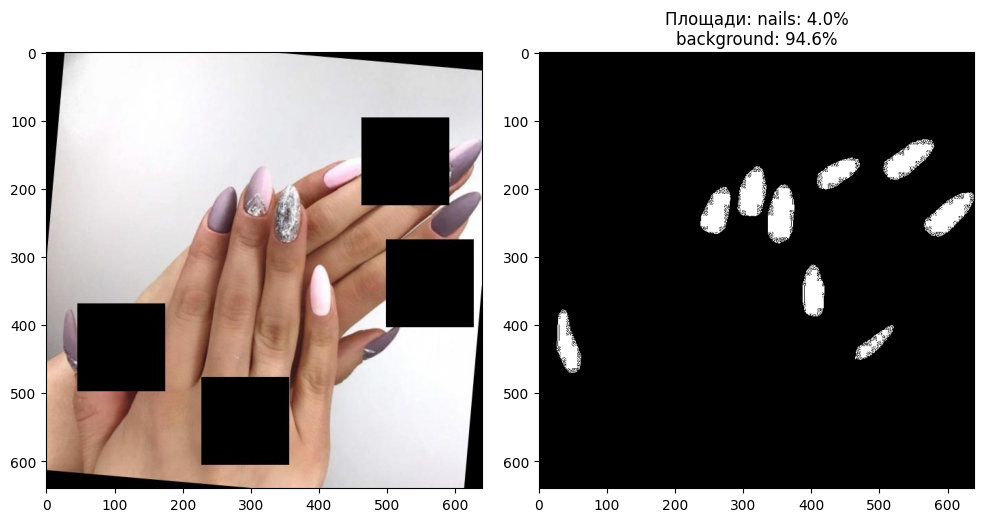

In [8]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
visualize_multichennel_mask(image, mask)

# Augmentations

In [9]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.Blur(blur_limit=[1, 3], p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации цвета
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    # Осуществит стартовую нормализацию данных согласно своим значениям или готовым для imagenet
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Применение аугментаций

C:\Users\Сергей\AppData\Roaming\Python\Python312\site-packages\albumentations\augmentations\blur\functional.py:148: UserWarning: blur_limit: Invalid kernel size range (1, 3). Values less than 3 are not allowed. Range automatically adjusted to (3, 3).
  result = _ensure_min_value(result, min_value, info.field_name)
c:\Users\Сергей\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...8, 0.0392156862745098)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


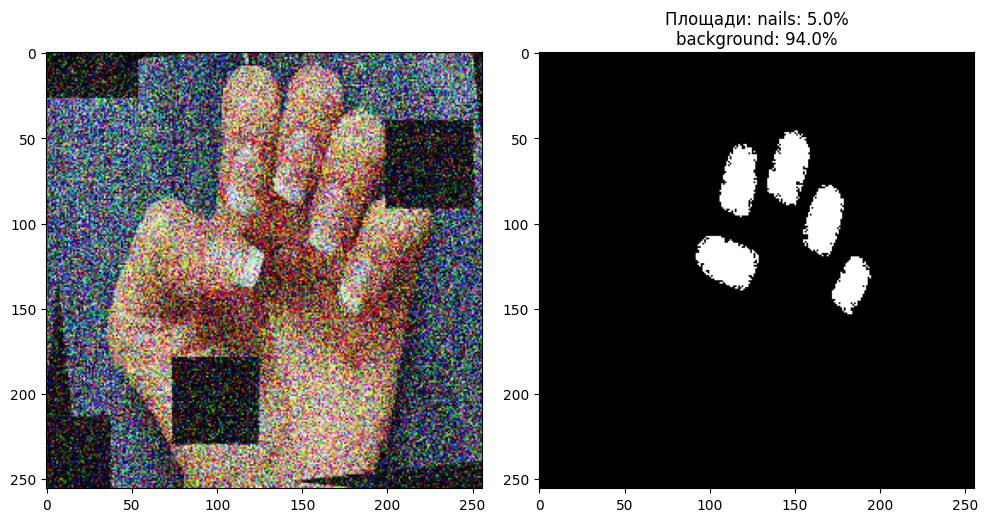

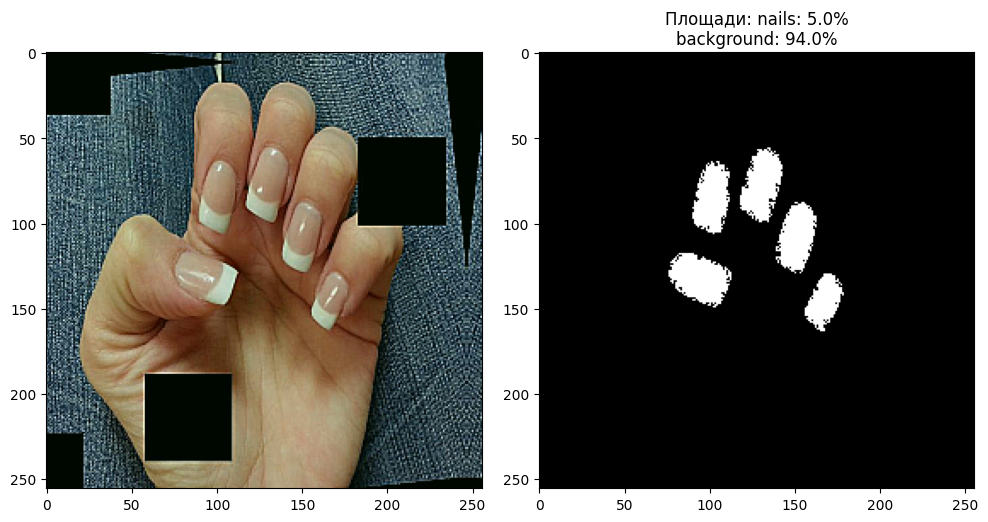

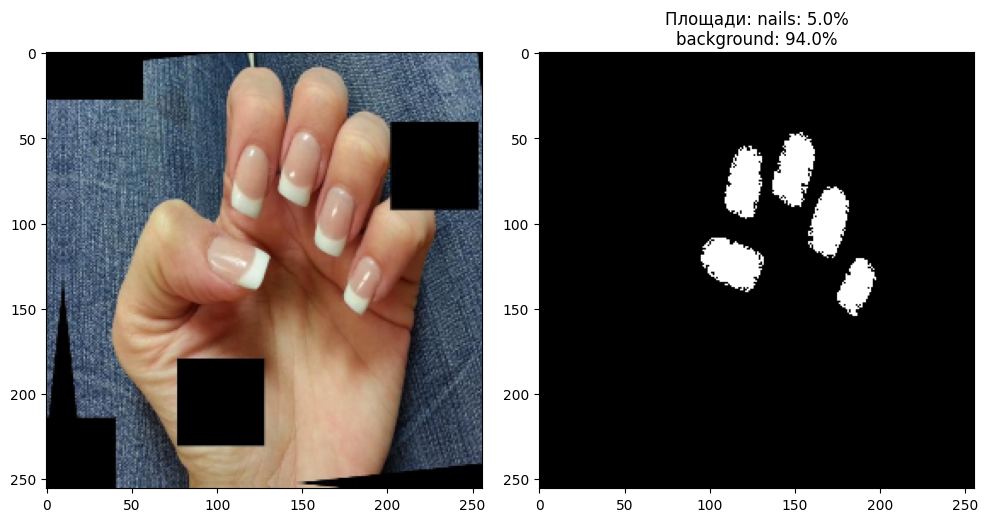

In [10]:
augmented_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

for i in range(3):
    image, mask = augmented_dataset[indx]
    visualize_multichennel_mask(image, mask)

Применение аугментаций на валидационном датасете

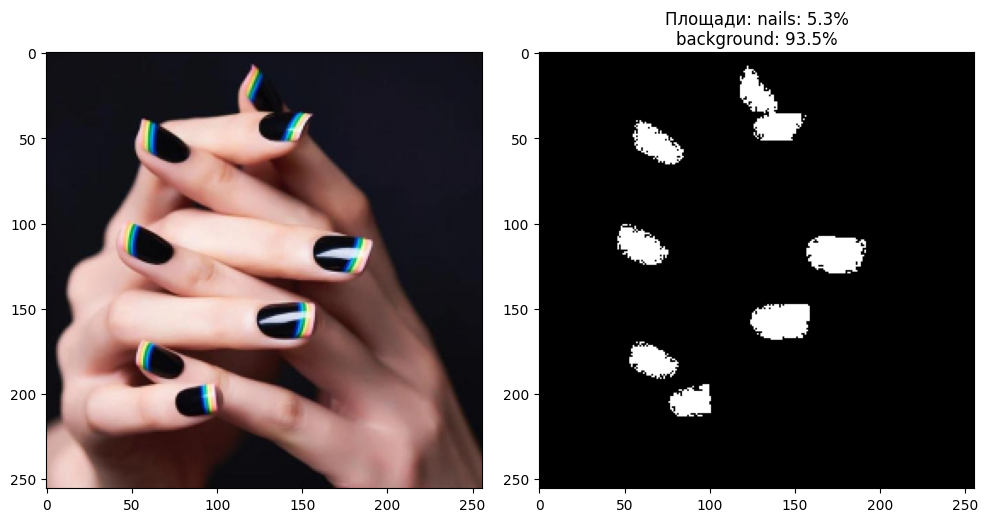

In [11]:
augmented_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichennel_mask(image, mask)

# Create and train model

In [12]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [13]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
#preprocessing_fn = lambda img, **kwargs: img.astype("float32") / 255    # -- классика деление на 255

In [15]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x000001EE91EBD4E0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [16]:
train_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [17]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=INIT_LR),
])

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

# Обучение

In [19]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}
for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_metric_IOU)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'models/best_model_new.pth')
        # Save the model with JIT
        # Create a tensor with the specified dimensions
        trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH)
        # Trace the model using the example input
        traced_model = torch.jit.trace(model, trace_image.to(DEVICE))
        torch.jit.save(traced_model, 'models/best_model_new.pt')
        print('Model saved!')

    print("LR:", optimizer.param_groups[0]['lr'])
    if i > 0 and i % LR_DECREASE_STEP == 0:
        print('Decrease decoder learning rate')
        optimizer.param_groups[0]['lr'] /= LR_DECREASE_COEF


Epoch: 0
valid: 100%|██████████| 99/99 [00:14<00:00,  6.63it/s, dice_loss - 0.02723, fscore - 0.9745, iou_score - 0.951] 


c:\Users\Сергей\AppData\Local\Programs\Python\Python312\Lib\site-packages\segmentation_models_pytorch\base\model.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Model saved!
LR: 0.0005

Epoch: 1
valid: 100%|██████████| 99/99 [00:13<00:00,  7.56it/s, dice_loss - 0.02096, fscore - 0.9797, iou_score - 0.9606]
Model saved!
LR: 0.0005

Epoch: 2
valid: 100%|██████████| 99/99 [00:13<00:00,  7.51it/s, dice_loss - 0.02025, fscore - 0.9802, iou_score - 0.9617]
Model saved!
LR: 0.0005

Epoch: 3
valid: 100%|██████████| 99/99 [00:13<00:00,  7.49it/s, dice_loss - 0.01853, fscore - 0.9818, iou_score - 0.9648]
Model saved!
LR: 0.0005

Epoch: 4
valid: 100%|██████████| 99/99 [00:13<00:00,  7.53it/s, dice_loss - 0.01846, fscore - 0.9818, iou_score - 0.9646]
LR: 0.0005

Epoch: 5
valid: 100%|██████████| 99/99 [00:13<00:00,  7.55it/s, dice_loss - 0.01829, fscore - 0.9819, iou_score - 0.9649]
Model saved!
LR: 0.0005

Epoch: 6
valid: 100%|██████████| 99/99 [00:12<00:00,  7.63it/s, dice_loss - 0.0199, fscore - 0.9814, iou_score - 0.9636] 
LR: 0.0005

Epoch: 7
valid: 100%|██████████| 99/99 [00:12<00:00,  7.67it/s, dice_loss - 0.01624, fscore - 0.9839, iou_score - 0.968

KeyboardInterrupt: 

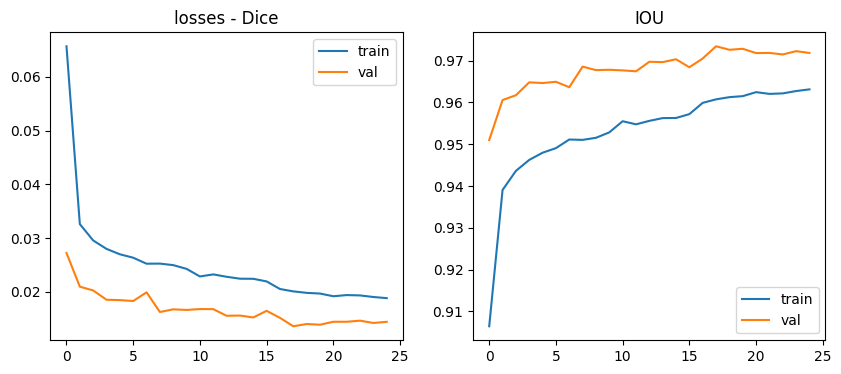

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs["train"], label = "train")
axes[0].plot(loss_logs["val"], label = "val")
axes[0].set_title("losses - Dice")

axes[1].plot(metric_logs["train"], label = "train")
axes[1].plot(metric_logs["val"], label = "val")
axes[1].set_title("IOU")

[ax.legend() for ax in axes];

# Test best saved model

In [21]:
# load best saved checkpoint
#best_model = torch.load('models/best_model_new.pth')
best_model = torch.jit.load('models/best_model_new.pt', map_location=DEVICE)

In [22]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [23]:
# оценка IoU
test_dataset = Dataset(
    X_TEST_DIR, 
    Y_TEST_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:   0%|          | 0/50 [00:00<?, ?it/s]

valid: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s, dice_loss - 0.0122, fscore - 0.9878, iou_score - 0.976]  


# Visualise prdictions

In [24]:
colors_imshow = {
        "background" : np.array([0, 0, 0]),
        "nails" : np.array([255, 255, 255]),
    }


def _colorize_mask(mask: np.ndarray):
    mask = mask.squeeze()
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    square_ratios = {}
    for cls_code, cls in enumerate(CLASSES):
        cls_mask = mask == cls_code
        square_ratios[cls] = cls_mask.sum() / cls_mask.size
        colored_mask += np.multiply.outer(cls_mask, colors_imshow[cls]).astype(np.uint8)

    return colored_mask, square_ratios


def reverse_normalize(img, mean, std):
    # Invert normalization
    img = img * np.array(std) + np.array(mean)
    return img

def visualize_predicts(img: np.ndarray, mask_gt: np.ndarray, mask_pred: np.ndarray, normalized=False):
    """
    Функция для визуализации изображения, GT маски (если есть) и предсказанной маски.
    
    Параметры:
    - img: np.ndarray — входное изображение (C, H, W или H, W, C).
    - mask_gt: np.ndarray — Ground Truth маска (может быть None, если отсутствует).
    - mask_pred: np.ndarray — Предсказанная маска.
    - normalized: bool — Указывает, нужно ли выполнить обратную нормализацию изображения.
    """
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Преобразование img в (H, W, C), если оно в формате (C, H, W)
    if img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
    
    # Обратная нормализация, если указано
    if normalized:
        img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    # Оригинальное изображение
    axes[0].imshow(img)
    axes[0].set_title("Оригинальное изображение")
    axes[0].axis("off")

    # GT маска (если предоставлена)
    if mask_gt is not None:
        mask_gt_colored, square_ratios_gt = _colorize_mask(mask_gt)
        title_gt = "GT маска\n" + "\n".join(
            [f"{cls}: {square_ratios_gt[cls]*100:.1f}%" for cls in CLASSES]
        )
        axes[1].imshow(mask_gt_colored, cmap="twilight")
        axes[1].set_title(title_gt)
        axes[1].axis("off")
    else:
        axes[1].imshow(np.zeros_like(img))
        axes[1].set_title("GT маска отсутствует")
        axes[1].axis("off")

    # Предсказанная маска
    mask_pred_colored, square_ratios_pred = _colorize_mask(mask_pred)
    title_pred = "PRED маска\n" + "\n".join(
        [f"{cls}: {square_ratios_pred[cls]*100:.1f}%" for cls in CLASSES]
    )
    axes[2].imshow(mask_pred_colored, cmap="twilight")
    axes[2].set_title(title_pred)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.288818357065736e-08..0.9999999964237213].


(256, 256) (3, 256, 256) (2, 256, 256)


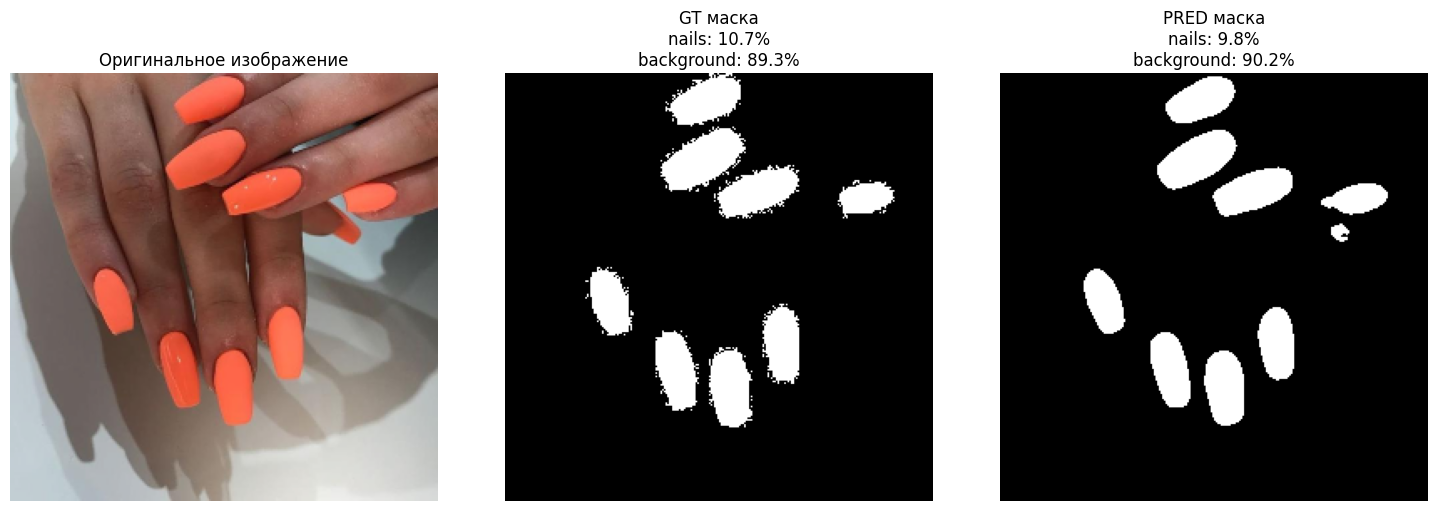

In [26]:
for i in range(1):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()
    
    label_mask = np.argmax(pr_mask, axis=0)
    print(label_mask.shape, image.shape, gt_mask.shape)

    visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

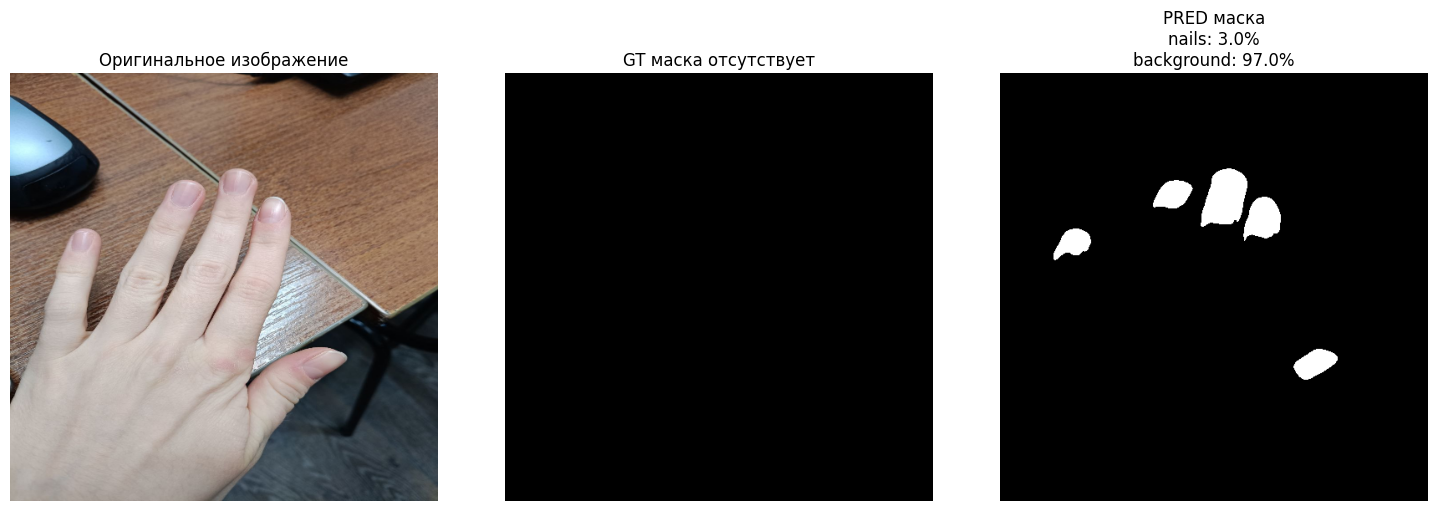

In [43]:
import cv2
import numpy as np
import torch

# Загружаем произвольное изображение
image_path = "../nail_segmentation/custom_pictures/Alina3.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB

# Предобработка: изменение размера и нормализация
image_resized = cv2.resize(image, (512, 512))  # Убедитесь, что размер совпадает с моделью
image_normalized = image_resized / 255.0           # Нормализация в диапазон [0, 1]
image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float()  # HWC -> CHW
image_tensor = image_tensor.to(DEVICE).unsqueeze(0)  # Добавляем батч

# Прогон через модель
with torch.no_grad():
    pr_mask = best_model(image_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy()  # Убираем батч и переносим в numpy

# Постобработка предсказания
label_mask = np.argmax(pr_mask, axis=0)  # Определяем класс для каждого пикселя

# Визуализация предсказания
visualize_predicts(image_resized, None, label_mask, normalized=False)